In [18]:
# based on https://pylessons.com/CartPole-reinforcement-learning

In [2]:
import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
env = gym.make('CartPole-v1')

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        # self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.fc2(x)
        # x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [5]:
from collections import deque

memory = deque(maxlen=2000)
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.999
epsilon_min = 0.001

min_train_size = 1000
batch_size = 64


In [6]:
model = MLP(4)

In [7]:
def remember(state, action, reward, next_state, done, i=-1):
    global epsilon
    memory.append(np.array([state, action, reward, next_state, done, i], dtype=object))
    if len(memory) > min_train_size and epsilon > epsilon_min:
        epsilon *= epsilon_decay

In [8]:
def choose_action(state):
    global epsilon
    if np.random.random() <= epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            return np.argmax(model(state).numpy())

In [9]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00025, alpha=0.95, eps=0.01)
minibatch = None
def replay():
    global minibatch
    # not enough samples
    if len(memory) < min_train_size:
        return
    minibatch = np.array(random.sample(memory, k=min(len(memory), batch_size)))

    state = torch.stack(tuple(minibatch[:, 0]))
    action = minibatch[:, 1].astype(int)
    reward = minibatch[:, 2].astype(float)
    next_state = torch.stack(tuple(minibatch[:, 3])).detach()
    done = minibatch[:, 4].astype(bool)

    with torch.no_grad():
        target = model(state).numpy()
        next_target = model(next_state).numpy()
    
    target[done, action[done]] = -100
    target[~done, action[~done]] = reward[~done] + gamma * np.max(next_target[~done])

    target = torch.FloatTensor(target)
    # train
    optimizer.zero_grad()
    q_values = model(state)
    loss = F.mse_loss(q_values, target)
    loss.backward()
    optimizer.step()

In [10]:
def replay():
    if len(memory) < min_train_size:
        return
    minibatch = random.sample(memory, min(len(memory), batch_size))

    state = torch.stack([m[0] for m in minibatch])
    action = torch.LongTensor([m[1] for m in minibatch])
    reward = torch.FloatTensor([m[2] for m in minibatch])
    next_state = torch.stack([m[3] for m in minibatch])
    done = torch.BoolTensor([m[4] for m in minibatch])
    steps = torch.LongTensor([m[5] for m in minibatch])

    with torch.no_grad():
        next_target = model(next_state)
        max_next_target = torch.max(next_target, dim=1)[0]
    
    target = model(state).detach()
    
    target[range(batch_size), action] = reward + gamma * max_next_target * (~done)
    premature_done = done & (steps < 500)
    target[premature_done, action[premature_done]] = -100

    # Compute the loss only for the actions taken
    q_values = model(state)
    q_values = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    # Get the targets for the actions taken
    target_action_values = target.gather(1, action.unsqueeze(1)).squeeze(1)

    loss = F.mse_loss(q_values, target_action_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for debugging
    print(f'Loss: {loss.item()}')

In [ ]:
episodes = 600
torch.set_grad_enabled(True)
model.train()

debug_i = []

for e in range(episodes):
    state, _ = env.reset()
    state = torch.tensor(state)
    done = False
    i = 0
    while not done:
        action = choose_action(state)
        next_state, reward, terminate, truncate, info = env.step(action)
        done = terminate or truncate
        next_state = torch.tensor(next_state)
        
        if done and i < 500:
            reward = -100
        # print(action, reward, done)
        remember(state, action, reward, next_state, done, i)
        state = next_state
        i += 1
        replay() # train from memory
    debug_i.append(i)


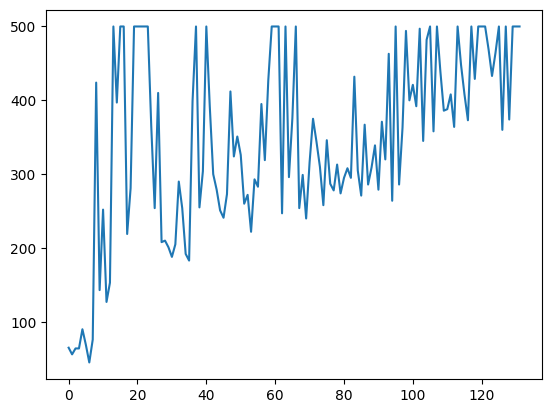

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(len(debug_i)), debug_i)

In [82]:
eval_env = gym.make('CartPole-v1', render_mode='human')

In [84]:
state, _ = eval_env.reset()
state = torch.tensor(state)
model(state)

tensor([23.1502, 23.5180])

In [ ]:
# test the model
model.eval()
torch.set_grad_enabled(False)
for e in range(10):
    reward_total = 0
    state, _ = eval_env.reset()
    state = torch.tensor(state)
    done = False
    i = 0
    while not done:
        eval_env.render()
        action = np.argmax(model(state).numpy())
        next_state, reward, terminate, truncate, info = eval_env.step(action)
        state = torch.tensor(next_state)
        done = terminate or truncate
        i += 1
        reward_total += reward
    print(f'episode: {e}, reward: {reward_total}')        


In [15]:
for m in memory:
    next_state, reward, terminate, truncate, info, i = m
    if reward < 0:
        print(m)

In [16]:
import pandas as pd

In [17]:
df = pd.DataFrame(memory)
df.describe()

,1,2,5
count,2000.000000,2000.000000,2000.000000
mean,0.496500,0.798000,240.113000
std,0.500113,4.513467,136.537103
min,0.000000,-100.000000,0.000000
25%,0.000000,1.000000,124.750000
50%,0.000000,1.000000,244.500000
75%,1.000000,1.000000,344.250000
max,1.000000,1.000000,499.000000
